# Determining asset classes using path signatures

In this notebook, we will look at timeseries data for various asset classes (stocks, cryptocurrencies, ETFs) and try to predict which type a given path belongs to. As training deep nets would require many examples (each of which will have a few hundred datapoints from the timeseries), we instead achieve this with comparatively few instances (~$1000$) using some tools from rough path theory - essentially by compressing each path to a smaller order and running a very simple regression/classification. 

In some ways, by using signatures, we're essentially adding (careful) bias to our model to point it to the right properties of a path that encode the class to which it belongs. The interesting difference compared with a other a priori models is that there is no need for any human knowledge to be injected here to help the model - as we will discuss, path signatures are a natural way to truncate the data.  

First we better be clear what we mean by a **path**: a continuous mapping $X : [a,b] \to \mathbb{R}^d $ from some interval to a Euclidean space. In our case, the interval will denote the time period, and our Euclidean space will be $\mathbb{R}^2$, since we will be looking at the price and the volume of the security traded as separate variables. 

To define the path signature, we need a few more auxiliary definitions. Let's start one-by one: 

1.   **Path integrals**: for the parametrized path $X = (X_{t}^{1},X_{t}^{2},... X_{t}^{d} $) and for a timepoint $t \in [a,b]$, we can define integrals along a dimension $i \in \{1,...,d\}$ as:

$$ S(X)_{a, t}^{i} = \int_{a < s < b} dX_{s}^{i} = X_{t}^{i}-X_{a}^{i}.$$

We can keep iterating this procedure by adding more integrals and considering more dimensions. The next level of complexity is the double iterated integral, first along a coordinate $i$ and then along a coordinate $j$:

$$ S(X)_{a, t}^{i, j} = \int_{a < s < b} S(X)_{a, s}^{i} dX_{s}^{j} = \int_{a < r < s < t} dX_{r}^{i} dX_{s}^{j}.$$

Proceeding, we can define the *k-fold iterated integral* $S(X)_{a,b}^{i_1,...,i_k}$ as follows:

$$ S(X)_{a, t}^{i_1, ..., i_k} = \int_{a < t_k < t} ... \int_{a < t_1 < t_2} dX_{t_1}^{i_1} ... dX_{t_k}^{i_k}.$$


Here, the superscripts will run along the set of all multi indices of the form $(i_1, ..., i_k)$, where $k \geq 1$ is an integer and each of the $i_j$'s are from a given coordinate of the path $\{1,...,d \}$.


2.   **Tensor algebra spaces**. We need some abstractions where our path signatures will live. We first define:

$$
(\mathbb{R}^d)^{\otimes n} = \mathbb{R}^d \otimes \mathbb{R}^d \otimes ... \otimes \mathbb{R}^d,
$$

where $n \in \mathbb{N}$ is the *tensor power* of the space and there are $n$ terms in the above product. The corresponding tensor algebra space is:

$$
T((\mathbb{R}^d)) = \{ (a_0, a_1,...) | a_n \in (\mathbb{R}^d)^{\otimes n}, \forall n \in \mathbb{N} \}.
$$

For practical applications we often truncate this space - for an integer $m$, we can define:

$$
T^{m}(\mathbb{R}^d)= \bigotimes_{i = 0}^{m} (\mathbb{R}^d)^{\otimes i}.
$$

3. **Signature**: (of a path $X$) denoted by $S(X)_{a,b}$, is an infinite dimensional vector of all the iterated integrals of the path $X$. Formally it can be represented as the sequence of real numbers:

$$
S(X)_{a,b} = (1, S(X)_{a,b}^{1}, ... , S(X)_{a,b}^{d}, S(X)_{a,b}^{1,1}, S(X)_{a,b}^{1,2}...).
$$

To connect signatures with the (more abstract) definition under point 2 above, we can alternatively write this as:

$$
S(X)_{a,b} = (1, X^1, X^2, ...) \in T((\mathbb{R}^d)),
$$

where for any $n \in \mathbb{N}$:

$$
X^{n} = {\int ... \int}_{a < t_1 <...t_n < b} dX_{t_1}^{i_1} \otimes ... \otimes dX_{t_n}^{i_n}.
$$

Often we'll be interested in the truncated signature (to a given order, say $m$), given by: 

$$
S^n(X)_{a,b} = (1, X^1, X^2, ... ,X^m) \in T^m(\mathbb{R}^d).
$$

We will call this the **path signature of order $m$**.

All the above is quite abstract, so we can give a simplified analogy as an example. Suppose that we have a mini-alphabet of only three letters, say $\{A, B, C \}$. If we think of integration along paths as sticking them together to form words, then the signature they generate will look like:

$$
(A, B, C, AA, AB, AC, BA, BB, BC, CA, CB, CC, AAA, AAB, AAC, ABA, ...).
$$

If we were to truncate this, say to second order, then we'd only consider words which have at most length two - we end up with: 

$$
(A, B, C, AA, AB, AC, BA, BB, BC, CA, CB, CC).
$$


### Why path signatures?

We defined paths above, but why are they a good choice for the problem at hand. We argue below: 

1. **Uniqueness (kind of)**: Clearly given a path we can uniquely construct the well-defined signature, but how about the the other way around? The answer is 'almost' - given bounded variation, the signature is unique up to tree-like equivalence. Hence, the signature is a good and shorter description of the path itself. 
2. **Truncation works**: If we have a couple of years of timeseries data (say 700 datapoints), it doesn't feel like we're simplifying the problem at all if we instead consider an infinitely dimensional signature for each such path. Instead, we need to put our hopes on truncation - the concern then is that we might be losing on information by only considering small and finite orders. This is not the case - given $X$ has bounded variation (loosely speaking meaning it is not infinitely oscillatory), higher order terms possess factorial decay: 

$$
\left| \left| {\int ... \int}_{a < t_1 <...t_n < b} dX_{t_1}^{i_1} ... dX_{t_n}^{i_n} \right| \right| \leq 
\frac{1}{n!} \text{sup}_{\{t_i\} ⊂ [a,b]} \sum_{i} |X_{t_{i+1}} - X_{t_{i}}|.
$$
3. **Signatures make simple linear models work**: In the classification problem at hand, we want to learn a function $f$ of the form $Y = f(X)$, where $X$ is a stream of price and volume data, and $Y$ is the actual type of security we are dealing with. It is a remarkable theorem (see [1]), that if we reduce $X$ to a compact set on the space of path signatures, the function $f$ we are looking for can be approximated arbitrarily well by linear functions.  


All this said, we now proceed by training a simple linear model on the transformed data (in the shape of truncated path signatures, one for each timeseries). 

In [3]:
# need pandas and numpy to deal with dataframes and arrays
import numpy as np
import pandas as pd

# importing things to handle dates and plot charts
import datetime 
import time
import numbers 
import matplotlib.dates as mdates
from random import shuffle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches

# we want to pull timeseries data from Yahoo Finance
# As of March 2022 this is best done via the yfinance API 
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 8.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
# To compute path signatures, we need a package from a GitHub repository
!pip install git+https://github.com/bottler/iisignature 

# Then we import everything that's in here
from iisignature import *

# We will need sklearn to do classical regressions. 
# Random forests are great since they are flexible and prevent overfitting
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

  Cloning https://github.com/bottler/iisignature to /tmp/pip-req-build-z0dv7d6s
  Running command git clone -q https://github.com/bottler/iisignature /tmp/pip-req-build-z0dv7d6s
  Created wheel for iisignature: filename=iisignature-0.24-cp37-cp37m-linux_x86_64.whl size=2522127 sha256=c0bff29a32300214b276e5eb10e02eadcf20d0649d7f6c20d36beb667edd3bf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-8spcahj5/wheels/13/02/c4/4fb22f79a642876ee2fdd84bd056596a4b7cb34af66c26de52
Successfully built iisignature


In [5]:
class Security:
    '''
    Store the information for a given security
    '''

    def __init__(self, data, asset_class):
        # Store the stream of data.
        self.data=np.array(data, dtype='float32')

        # Store the asset classs the security belongs to.
        self.asset_class=asset_class

        # Since the output to train the model must
        # be a vector, each asset will be given
        # by a point, which is calculated using
        # the function asset_class_to_point.
        self.point=asset_class_to_point(asset_class)

In [6]:
def getData(ticker):
	'''
		Gets data from the specified ticker, for a set time period.
	'''

	security = yf.Ticker(ticker).history(start = "2019-01-01", end = "2021-01-01")
	values=security[["Close", "Volume"]].reset_index().values

	for i in range(len(values)):
		values[i][0]=string2datenum(str(values[i][0]), "%Y-%m-%d %H:%M:%S")

	return values


In [7]:
# to apply regression methods, we need to add coordinates to each country
# then, the output will be matched to whatever coordinate is closest to it

def asset_class_to_point(asset_class):
    '''
    Converts a sector into a point
    '''
    dictionary={"Stocks": (1,0), "Cryptocurrencies": (-1, 0), "ETFs": (0,1)}
    return dictionary[asset_class]


# we don't care about actual dates (eg. Nov 5th 1998 vs Nov 5th 2018)
# what matters is the indexing so we make each day an integer

def string2datenum(s, f):
	'''
		Converts a string date in format f to a number

		Arguments:
			s: string, date that has to be converted to int
			f: string, format of s
	'''
	return mdates.date2num(datetime.datetime.fromtimestamp(time.mktime(time.strptime(s, f))))

def findMin(p, A):
	'''
		Finds the point in A that is closest to p.
	'''
	minimum=(-1, (0,0))
	for p0 in A:
	        dist=np.linalg.norm(p0-np.array(p))
	        if minimum[0]==-1 or minimum[0]>dist:
	                minimum=(dist, p0)
	return minimum[1]

def accuracy(predictions, y):
	'''
		Given a list of predictions and a list of correct values y,
		it calculates the accuracy of the predictions (as a percentage
		of correct guesses).
	'''
	points=[[1,0], [-1, 0], [0, 1]]
	performance={"guesses": 0.0, "total": 0.0}

	for i in range(len(y)):
	  if set(findMin(predictions[i], points))==set(y[i]):
	    performance["guesses"]+=1
	  performance["total"]+=1

	return performance["guesses"]/performance["total"]


Let's just check the first couple of rows to varify that our function actually returns an array with the day, the relevant price and volume of the security. We'll take BMW as an example here:

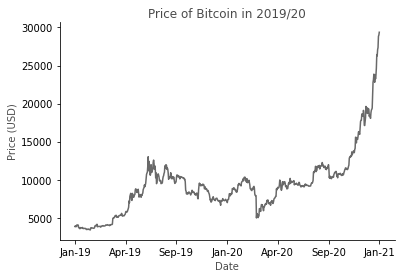

In [44]:
bitcoin = pd.DataFrame(data = getData('BTC-USD'), columns = ['Date', 'Price', 'Volume'])
bitcoin.set_index('Date')
plt.plot(bitcoin['Date'], bitcoin['Price'], color = 'dimgray')
plt.xlabel('Date', alpha = 0.7);
plt.ylabel('Price (USD)', alpha = 0.7);
plt.title('Price of Bitcoin in 2019/20', alpha = 0.7);
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
my_ticks = ['Jan-19', 'Apr-19', 'Sep-19', 'Jan-20', 'Apr-20', 'Sep-20', 'Jan-21']
plt.xticks(np.linspace(737060, 737791, 7), my_ticks);

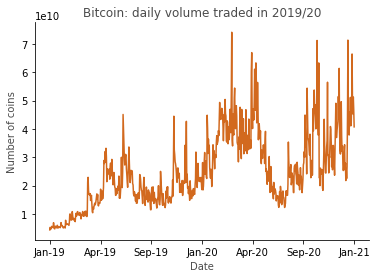

In [45]:
plt.plot(bitcoin['Date'], bitcoin['Volume'], color = 'chocolate')
plt.xlabel('Date', alpha = 0.7);
plt.ylabel('Number of coins', alpha = 0.7);
plt.title('Bitcoin: daily volume traded in 2019/20', alpha = 0.7);
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
my_ticks = ['Jan-19', 'Apr-19', 'Sep-19', 'Jan-20', 'Apr-20', 'Sep-20', 'Jan-21']
plt.xticks(np.linspace(737060, 737791, 7), my_ticks);

In [8]:
securities = {'Cryptocurrencies': ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'USDC-USD', 'LUNA1-USD', 'XRP-USD', 'ADA-USD', 'SOL-USD', 'HEX-USD', 'AVAX-USD', 'BUSD-USD', 'DOT-USD', 'DOGE-USD',
                                   'UST-USD', 'UST-USD', 'SHIB-USD', 'MATIC-USD', 'WBTC-USD', 'CRO-USD', 'DAI-USD', 'ATOM-USD', 'NEAR-USD', 'LTC-USD', 'LINK-USD', 'TRX-USD', 'WTRX-USD', 'UNI1-USD',
																	  'WTRX-USD', 'UNI1-USD', '	FTT-USD', 'LEO-USD', 'BCH-USD', 'STETH-USD', 'ALGO-USD', 'XLM-USD', 'MANA-USD', 'HBAR-USD', 'ETC-USD', 'ICP-USD', 'SAND-USD', 'FTM-USD',
																		'FIL-USD', 'XMR-USD', 'EGLD-USD', 'VET-USD', 'WAVES-USD', 'KLAY-USD', 'FRAX-USD', 'THETA-USD', 'AXS-USD', 'OSMO-USD', 'XTZ-USD', 'HNT-USD', 'TONCOIN-USD', 'MIOTA-USD',
																		'FLOW-USD', 'ZEC-USD', 'WBNB-USD', 'EOS-USD', 'STX-USD', 'MKR-USD', 'BTT-USD', 'RUNE-USD', 'CAKE-USD', 'BTT2-USD', 'AAVE-USD', 'HBTC-USD', 'XEC-USD', 'GRT1-USD', 
																		'GALA-USD', 'BSV-USD', 'ONE1-USD', 'TUSD-USD', 'KCS-USD', 'NEO-USD', 'HT-USD', 'QNT-USD', 'CHZ-USD', 'NEXO-USD', 'ENJ-USD', 'CELO-USD', 'CBG-USD', 'AMP-USD', 'AR-USD',
																		'KSM-USD', 'OKB-USD', 'KDA-USD', 'DASH-USD', 'DFI-USD', 'BAT-USD', 'ANC1-USD', 'LRC-USD', 'USDP-USD', 'CRV-USD', 'XEM-USD', 'CVX-USD', 'TFUEL-USD', 'YOUC-USD',
																		'ROSE-USD', 'XYM-USD', 'DCR-USD', 'CEL-USD', 'SCRT-USD', 'LN-USD', 'BORA-USD', 'LUSD-USD', 'MINA-USD', 'OMI-USD', 'YFI-USD', 'HOT1-USD', 'COMP1-USD', 'VBNB-USD',
																		'IOTX-USD', 'XDC-USD', 'BIT1-USD', 'ANKR-USD', 'CCXX-USD', 'ICX-USD', 'PAXG-USD', 'SXP-USD', 'OMG-USD', 'QTUM-USD', 'RENBTC-USD', 'WEMIX-USD', 'RNDR-USD','USDN-USD', 
																		'NXM-USD', 'BNT-USD', '1INCH-USD', 'WAXP-USD', 'GNO-USD', 'KOK-USD', 'RVN-USD', 'BTG-USD', 'TTT1-USD', 'ZIL-USD', 'SNX-USD', 'LPT-USD', 'VLX-USD', 'KNC-USD', 'KAVA-USD',
																		'GT-USD', 'UMA-USD', 'RLY-USD', 'ZEN-USD', 'GLMR-USD', 'GLM-USD', 'WOO-USD', 'SC-USD', 'AUDIO-USD', 'CHSB-USD', 'NFT1-USD', 'ONT-USD', 'VGX-USD', 'ZRX-USD', 
																		'METIS-USD', 'FEI-USD', 'KEEP-USD', 'IOST-USD', 'STORJ-USD', 'XWC-USD', 'REV1-USD', 'REN-USD', 'ELON-USD', 'SKL-USD', 'SUSHI-USD', 'HUSD-USD', 'HIVE-USD', 'JST-USD', 
																		'RACA-USD', 'POLY-USD', 'IMX1-USD', 'MOB-USD', 'UOS-USD', 'ILV-USD', 'BTRST-USD', 'CKB-USD', 'SYS-USD', 'DYDX-USD', 'NU-USD', 'SPELL-USD', 'DGB-USD', 'GUSD-USD', 'PERP-USD', 
																		'SAPP-USD', 'PEOPLE-USD', 'TEL-USD', 'PLA3-USD', 'SAFEMOON-USD', 'YGG-USD', 'ENS-USD', 'LSK-USD', 'BEST-USD', 'OCEAN-USD', 'XDB-USD', 'FXS-USD', 'XPRT-USD', 'RPL-USD', 
																		'SAFE1-USD', 'DESO-USD'],
														
              'Stocks': ['ADM.L', 'AGK.L', 'AMEC.L', 'AAL.L', 'ANTO.L', 'ARM.L', 'ABF.L', 'AZN.L', 'AV.L', 'BAB.L', 'BA.L', 'BARC.L', 'BG.L', 'BLT.L', 'BP.L', 'BLND.L','BSY.L', 'BNZL.L', 'BRBY.L', 
							                  'CPI.L', 'CNA.L', 'CPG.L', 'CRH.L', 'CRDA.L', 'DGE.L', 'ENRC.L', 'EVR.L', 'EXPN.L', 'FRES.L', 'GFS.L', 'GKN.L', 'GSK.L', 'GLEN.L', 'HMSO.L', 'HL.L', 'HSBA.L', 'IMI.L', 
																'IHG.L', 'IAG.L', 'ITRK.L', 'ITV.L', 'SBRY.L', 'JMAT.L', 'KGF.L', 'LAND.L', 'LGEN.L', 'LLOY.L', 'MKS.L', 'MGGT.L', 'MRO.L', 'MRW.L', 'NG.L', 'NXT.L', 'OML.L', 'PFC.L', 
																'PRU.L', 'RRS.L', 'RB.L', 'REL.L', 'FLG.L', 'REX.L', 'RIO.L', 'RR.L', 'RBS.L', 'RDSA.L', 'RSA.L', 'SAB.L', 'SGE.L', 'SDR.L', 'SRP.L', 'SVT.L', 'SNN.L', 'SMIN.L', 'SSE.L', 
																'STAN.L', 'SL.L', 'TATE.L', 'TSCO.L', 'TT.L', 'TLW.L', 'ULVR.L', 'UU.L', 'VED.L', 'VOD.L', 'WEIR.L', 'WTB.L', 'WOS.L', 'WPP.L', 'XTA.L' 'ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 
																'BMW.DE', 'BEI.DE', 'CBK.DE', 'CON.DE', 'DAI.DE', 'DBK.DE', 'DB1.DE', 'LHA.DE', 'DPW.DE', 'DTE.DE', 'EOA.DE', 'FME.DE', 'FRE.DE', 'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LIN.DE', 'MRK.DE', 
																'MUV2.DE', 'PSM.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'TKA.DE', 'VOW3.DE', 'VNA.DE', 'MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AAP', 'AES', 'AET', 'AMG', 'AFL', 'A', 'APD', 
																'AKAM', 'ALK', 'ALB', 'ALXN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 
																'APC', 'ADI', 'ANTM', 'AON', 'APA', 'AIV', 'AAPL', 'AMAT', 'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AN', 'AZO', 'AVB', 'AVY', 'BHI', 'BLL', 'BAC', 'BCR', 'BAX', 'BBT', 'BDX', 
																'BBBY', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBG', 'CBS', 'CELG', 
																'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CHK', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CME', 'CMS', 'COH', 'KO', 'CTSH', 'CL', 'CMCSA', 
																'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'GLW', 'COST', 'COTY', 'CCI', 'CSRA', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DLPH', 'DAL', 'XRAY', 'DVN', 'DLR', 'DFS', 'DISCA', 
																'DISCK', 'DG', 'DLTR', 'D', 'DOV', 'DOW', 'DPS', 'DTE', 'DD', 'DUK', 'DNB', 'ETFC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ETR', 'EVHC', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 
																'ESS', 'EL', 'ES', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FTI', 'FL', 'F', 'FTV', 
																'FBHS', 'BEN', 'FCX', 'FTR', 'GPS', 'GRMN', 'GD', 'GE', 'GGP', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GS', 'GT', 'GWW', 'HAL', 'HBI', 'HOG', 'HAR', 'HRS', 'HIG', 'HAS', 'HCA', 'HCP', 'HP', 'HSIC', 
																'HES', 'HPE', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HPQ', 'HUM', 'HBAN', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IBM', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IRM', 'JBHT', 'JEC', 
																'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS', 'KHC', 'KR', 'LB', 'LLL', 'LH', 'LRCX', 'LEG', 'LEN', 'LUK', 'LVLT', 'LLY', 'LNC', 'LLTC', 'LKQ', 'L', 
																'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MNK', 'MRO', 'MPC', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MCK', 'MJN', 'MDT', 'MRK', 'MET', 'MTD', 'KORS', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 
																'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MSI', 'MUR', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NTAP', 'NFLX', 'NFX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'JWN', 'NSC', 'NTRS', 'NOC', 'NRG', 
																'NUE', 'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'PCAR', 'PH', 'PDCO', 'PAYX', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'RL', 'PPG', 'PPL', 
																'PX', 'PCLN', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'QCOM', 'PWR', 'DGX', 'RRC', 'RTN', 'O', 'RHT', 'REG', 'REGN', 'RF', 'RSG', 'RAI', 'RHI', 'ROK', 'COL', 'ROP', 
																'ROST', 'RCL', 'R', 'SPGI', 'CRM', 'SCG', 'SLB', 'SNI', 'STX', 'SEE', 'SRE', 'SHW', 'SIG', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWN', 'SWK', 'SPLS', 'SBUX', 'STT', 'SRCL', 'SYK', 'STI', 
																'SYMC', 'SYF', 'SYY', 'TROW', 'TGT', 'TEL', 'TGNA', 'TDC', 'TSO', 'TXN', 'TXT', 'BK', 'CLX', 'COO', 'HSY', 'MOS', 'TRV', 'DIS', 'TMO', 'TIF', 'TWX', 'TJX', 'TMK', 'TSS', 'TSCO', 'TDG', 'RIG', 
																'TRIP', 'FOXA', 'FOX', 'TSN', 'USB', 'UDR', 'ULTA', 'UA', 'UAA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'URBN', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 
																'V', 'VNO', 'VMC', 'WMT', 'WBA', 'WM', 'WAT', 'WEC', 'WFC', 'HCN', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WFM', 'WMB', 'WLTW', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YHOO', 'YUM', 'ZBH', 
																'ZION', 'ZTS'],
														
							'ETFs': ['QYLD', 'TNA', 'TZA', 'KRBN', 'FXI', 'SARK', 'VHT', 'MGK', 'VB', 'IJR', 'XEG.TO', 'SCHG', 'VBR', 'VO', 'VBK', 'GRN', 'SCHX', 'COWZ', 'IJH', 'VOT', 'JSTC', 'VOE', 'VV', 'XSP.TO', 'QYLG', 
							         'SCHV', 'POTX', 'SCHA', 'MGV', 'FHLC', 'TXF.TO', 'YOLO', 'ZWC.TO', 'AMJ', 'AVUV', 'ZQQ.TO', 'XIC.TO', 'EWC', 'ZWU.TO', 'HYLD.TO', 'MGC', 'VSP.TO', 'KEUA', 'XIT.TO', 'ZWB.TO', 'FNGG', 'VIOV',
											     'SLYV', 'VCN.TO', 'CGXF.TO', 'CALF', 'TAIL', 'HEU.TO', 'BBCA', 'SCHM', 'THCX', 'VIOO', 'KCCA', 'SCZ', 'SPSM', 'SMOG', 'FTCS', 'CNBS', 'IWR', 'ZWE.TO', 'IHF', 'NXF.TO', 'XDIV.TO',
													   'AVDV', 'ZWK.TO', 'IJJ', 'IWS', 'XRE.TO', 'SLY', 'XFN.TO', 'VIU.TO', 'XYLG', 'HCAL.TO', 'ZDV.TO', 'MIDU', 'XHE', 'FXC', 'SCHC', 'MNT.TO', 'EYLD', 'SYLD', 'SMIN', 'IJT', 'XDV.TO', 
														  'PAWZ', 'TOKE', 'RIET', 'EWZS', 'PINK', 'ZLB.TO', 'KCE', 'SPMD', 'XMA.TO', 'ZCN.TO', 'SVAL', 'HED.TO', 'ZUB.TO', 'HFU.TO', 'KBWP', 'CNCR', 'CYA', 'FXH', 'BKLC', 'GMOM', 'CSB', 'RIT.TO', 
															 'CGUS', 'TTP.TO', 'XHS', 'TRTY', 'SCJ', 'VE.TO', 'CIC.TO', 'IVOG', 'AVLV', 'FAB', 'FLCA', 'UTRN', 'XCV.TO', 'LGLV', 'LOWC', 'OUSM', 'XSU.TO', 'FEX', 'EWGS', 'TDSC', 'PWZ', 'VAMO', 'DISC.TO',
															 'FCCV.TO', 'ECLN', 'FSMO', 'NUMV', 'QRFT', 'NUSC', 'ZHY.TO', 'JHMM', 'ROOF', 'XCG.TO', 'RXD', 'CGCP', 'ZUH.TO', 'FTA', 'USMC', 'ZUE.TO']
}

In [10]:
data=[]

for asset_class in securities:
	print("Loading companies from "+asset_class+"...")
 
	for security in securities[asset_class]:
		securityData=getData(security) 
	# If the company doesn't have any data, ignore it.
		if len(securityData)==0: continue

		data.append(Security(securityData, asset_class))
	print("Done.")

Loading companies from Cryptocurrencies...
- WTRX-USD: No data found for this date range, symbol may be delisted
- WTRX-USD: No data found for this date range, symbol may be delisted
- 	FTT-USD: No data found, symbol may be delisted
- ICP-USD: No data found for this date range, symbol may be delisted
- OSMO-USD: Data doesn't exist for startDate = 1546300800, endDate = 1609459200
- TONCOIN-USD: Data doesn't exist for startDate = 1546300800, endDate = 1609459200
- FLOW-USD: No data found for this date range, symbol may be delisted
- BTT2-USD: No data found for this date range, symbol may be delisted
- XEC-USD: Data doesn't exist for startDate = 1546300800, endDate = 1609459200
- CBG-USD: Data doesn't exist for startDate = 1546300800, endDate = 1609459200
- ANC1-USD: Data doesn't exist for startDate = 1546300800, endDate = 1609459200
- CVX-USD: Data doesn't exist for startDate = 1546300800, endDate = 1609459200
- XYM-USD: Data doesn't exist for startDate = 1546300800, endDate = 1609459200

In [14]:
shuffle(data)

# Not a lot of data so we use 80% to train, 20% to test as in classical approaches
training_set=data[0:int(0.8*len(data))]

testing_set=[security for security in data if security not in training_set]

print('There are ' + str(len(data)) + ' timeseries in this dataset post filtering.')
print('There were ' + str(len(securities['Cryptocurrencies']) + len(securities['Stocks']) + len(securities['ETFs'])) + ' timeseries in this dataset to begin with.')

There are 834 timeseries in this dataset post filtering.
There were 971 timeseries in this dataset to begin with.


In [15]:
inputs=[security.data for security in training_set]
outputs=[security.point for security in training_set]

# Inputs and outputs to test the model are built.
inputsTEST=[security.data for security in testing_set]
outputsTEST=[security.point for security in testing_set]

good_data = []
for i in range(len(inputs)):
  if np.sum(inputs[i]) > 0:
    good_data.append(i)


good_data_TEST = []
for i in range(len(inputsTEST)):
  if np.sum(inputsTEST[i]) > 0:
    good_data_TEST.append(i)

inputs = [inputs[i] for i in good_data]
outputs = [outputs[i] for i in good_data]
inputsTEST = [inputsTEST[i] for i in good_data_TEST]
outputsTEST = [outputsTEST[i] for i in good_data_TEST]


In [16]:
class sigLearn:
    def __init__(self, order=2, alpha=0.1):
        if not isinstance(order, numbers.Integral) or order<1:
            raise NameError('The order must be a positive integer.')
        if not isinstance(alpha, numbers.Real) or alpha<=0.0:
            raise NameError('Alpha must be a positive real number.')
        self.order=int(order)
        self.reg=None
        self.alpha=alpha


    def train(self, x, y):
        '''
        Trains the model using signatures.
        
        x: list of inputs, where each element of
            the list is a list of tuples.
        y: list of outputs.
        '''

        # We check that x and y have appropriate types
        if x is None or y is None:
            return
        if not (type(x) is list or type(x) is tuple) or not (type(y) is list or type(y) is tuple):
            raise NameError('Input and output must be lists or tuples.')
        if len(x)!=len(y):
            raise NameError('The number of inputs and the number of outputs must coincide.')
        ###
        
        X=[list(sig(np.array(stream), self.order))
                for stream in x]
        self.reg = linear_model.Lasso(alpha = self.alpha)
        self.reg.fit(X, y)
        
    def predict(self, x):
        '''        
        Predicts the outputs of the inputs x using the
        pre-trained model.
        x: list of inputs, where each element of
            the list is a list of tuples.

        Returns:

        list of predicted outputs.        
        '''
        if self.reg is None:
            raise NameError('The model is not trained.')

        X=[list(sig(np.array(stream), self.order))
                for stream in x]
 
        return self.reg.predict(X)

In [17]:
# create a list of the orders of path signatures 
siglist = [i for i in range(1,9)]

# create a list of the corresponding model-predicted accuracies
# empty for now and will be filled as we build the model
accuracylist = []

# iterate along the path signatures and train the model
for signorder in siglist:
    # build a model based on the signature order
    model=sigLearn(order=signorder);
    # train a classifier via 
    model.train(inputs, outputs);

    # We calculate the predictions.
    predictions=model.predict(inputsTEST);
    # Now put everything in our aggregated list
    accuracylist.append(accuracy(predictions, outputsTEST));

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.250e+02, tolerance: 4.178e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.524e+01, tolerance: 9.155e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

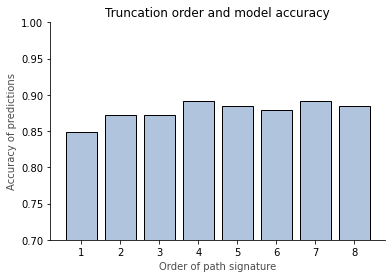

In [19]:
plt.bar(siglist, accuracylist, color = 'lightsteelblue', edgecolor = 'black');
plt.xlabel('Order of path signature', alpha = 0.7);
plt.ylabel('Accuracy of predictions', alpha = 0.7);
plt.title('Truncation order and model accuracy');
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0.7,1);

### Bibliography
[1] Levin, D., Lyons, T., Ni, H. (2016) "Learning from the past, predicting the statistics for the future, learning an evolving system, 1309.0260"

[2] Lyons, T., Lévy, T., Caruana, M. (2006) Differential Equations driven by Rough Paths, Springer

[3] Rough Path Theory and Signatures Applied To Quantitative Finance (https://www.quantstart.com/articles/rough-path-theory-and-signatures-applied-to-quantitative-finance-part-1/)

[4] Chevyrev, I., Kormilitzin, A. (2016) "A Primer on the Signature Method in Machine Learning, arXiv:1603.03788v1"